# Model Training and Evaluation

## Importing Libraries & Loading Data

In [1]:
# Ignore Warnings
import warnings

import dill

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Imputation - RandomForest
from sklearn.ensemble import RandomForestRegressor

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
import math
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

# Regression Algorithms
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')  # Disabling warning outputs

In [2]:
# Path to the CSV data file
PROCESSED_DATASET_PATH = "../data/dynamic_pricing_processed.csv" 

# Reading data from the CSV file into a DataFrame using the first column as the index
df = pd.read_csv(PROCESSED_DATASET_PATH)

# Displaying the first few rows of the DataFrame
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,demand_multiplier,supply_multiplier,adjusted_ride_cost,profit_percentage
0,90,4.178331,Urban,Silver,13,4.47,Night,Premium,90,284.257273,1.111111,0.844444,5.589906,-6.172840
1,58,4.012805,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,1.450000,0.974359,5.507986,41.282051
2,42,3.750677,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,1.050000,1.225806,6.053215,28.709677
3,89,3.635872,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,1.098765,1.357143,6.554155,49.118166
4,78,3.367538,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,1.950000,1.727273,7.577364,236.818182


# <a id='sixth'></a> Data Splitting

In [3]:
# Create the TRAIN subset by selecting rows where the target variable TARGET is not null
TARGET = df['adjusted_ride_cost']

# Create the TEST subset by selecting rows where the target variable TARGET is null
df = df.drop(columns=['adjusted_ride_cost'])

In [4]:
# Count the number of columns for each data type and display the counts
df.dtypes.value_counts()

float64    6
object     4
int64      3
Name: count, dtype: int64

### Polynomial Feature Engineering

In this section of code, polynomial feature engineering is performed to create a new feature based on the relationship between the number of riders and the number of drivers. Here's a detailed explanation of the process:

1. **Mapping Vehicle Type**:
   - The 'Vehicle_Type' column in the DataFrame is mapped to numerical values. 'Economy' is assigned 0, and 'Premium' is assigned 1.

2. **Feature Selection**:
   - The feature matrix \( X \) is constructed from the DataFrame, including features such as 'Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration', and 'Vehicle_Type'.

3. **Polynomial Fitting**:
   - A second-degree polynomial is fitted to the relationship between the number of riders and the number of drivers using the `np.polyfit()` function.
   - This step calculates the coefficients of the polynomial that best fits the data.

4. **Creating Polynomial Feature**:
   - A polynomial is created based on the coefficients obtained from the polynomial fitting using the `np.poly1d()` function.
   - This polynomial represents the relationship between the number of riders and the number of drivers.

5. **Calculating Interpolated Division**:
   - Values of the polynomial are computed for a new feature, 'interpolated_division', which is calculated as the division of the number of riders by the number of drivers.
   - This step effectively interpolates the division feature using the polynomial relationship.

6. **Conversion to Series**:
   - The interpolated division feature is converted back to a Series object and added to the DataFrame as a new column.

This process enhances the feature set by incorporating a derived feature that captures the complex relationship between the number of riders and the number of drivers, potentially improving the performance of machine learning models trained on this data.

In [5]:
df['Vehicle_Type'] = df['Vehicle_Type'].map({'Economy': 0, 'Premium': 1})

X = df[['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration', 'Vehicle_Type']]

coefficients = np.polyfit(X['Number_of_Riders'].values, X['Number_of_Drivers'].values, deg=2)

poly = np.poly1d(coefficients)

division_feature = poly(X['Number_of_Riders'].values / X['Number_of_Drivers'].values)

X['interpolated_division'] = pd.Series(division_feature)

### Standardizing Features with StandardScaler

In this section, we standardize the features in the dataset \(X\) using the StandardScaler class from scikit-learn.

1. **StandardScaler Instance Creation:**  
   An instance of StandardScaler named `scaler` is created using the StandardScaler class. This instance will be used to standardize the features.

2. **Feature Scaling:**  
   The `fit_transform` method of the `scaler` object is called with the feature matrix \(X\) as input. This method computes the mean and standard deviation of each feature in \(X\) and then standardizes the features by subtracting the mean and dividing by the standard deviation.

In [ ]:
# Assign the target vector y to the non-null values of the TARGET variable
y = TARGET

# Create an instance of StandardScaler
scaler = StandardScaler()

# Scale the features in X using StandardScaler and fit_transform method
X_scaled = scaler.fit_transform(X)

# Save the scaler to a file
with open('../models/standard_scaler.pkl', 'wb') as file:
    dill.dump(scaler, file)

In [7]:
# Split the scaled features and the target variable y into training and testing sets
# The test set will be 30% of the total data, and the random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# <a id='seventh'></a> Model Training

### Model Evaluation with Grid Search and Cross-Validation

This code snippet demonstrates the process of evaluating multiple machine learning models using grid search and cross-validation. The goal is to find the best-performing model based on the R-squared score and root mean squared error (RMSE) on a test set.

#### Steps:
1. **Initialization**: 
   - An empty list `results` is initialized to store the evaluation results of each model.
   - Variables `best_model` and `best_r2` are initialized to track the best model and its R-squared score, respectively.

2. **Model Evaluation Loop**:
   - Iterate over each model in the `models` dictionary, which contains the names and instances of different machine learning models.
   - Create a pipeline with the current model.
   - Perform grid search with cross-validation using `GridSearchCV`. If hyperparameters are defined for the model in the `params` dictionary, grid search is performed with those hyperparameters; otherwise, default hyperparameters are used.
   - Fit the grid search to the training data.
   - Make predictions on the test set using the best model obtained from grid search.
   - Calculate the R-squared score and RMSE on the test set.
   - Update the `best_model` and `best_r2` variables if the current model performs better than the previous best model.
   - Append the evaluation results (model name, R-squared score, RMSE score, and best parameters) to the `results` list.

3. **Results DataFrame**:
   - Create a DataFrame `results_df` from the `results` list containing the evaluation results for each model.

#### Benefits:
- **Automated Model Selection**: Grid search with cross-validation automates the process of hyperparameter tuning, making it easier to find the best-performing model.
- **Comprehensive Evaluation**: The evaluation results include both R-squared score and RMSE, providing insights into model performance.

#### Considerations:
- **Computational Complexity**: Grid search with cross-validation can be computationally expensive, especially for large datasets and complex models.
- **Overfitting**: Care should be taken to prevent overfitting by using appropriate regularization techniques and validation strategies.


In [8]:
# Building Pipeline
# Dictionary containing regression models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    'CatBoostRegressor': CatBoostRegressor(verbose=0)
}

# Dictionary containing hyperparameter grids for each model
params = {
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.001, 0.01, 0.1]},
    'ElasticNet': {'model__alpha': [0.001, 0.01, 0.1], 'model__l1_ratio': [0.2, 0.5, 0.8]},
    'SVR': {'model__C': [0.1, 1, 10], 'model__epsilon': [0.1, 0.2, 0.5], 'model__kernel': ['linear', 'rbf']},
    'RandomForestRegressor': {'model__n_estimators': [10, 50, 100]},
    'XGBRegressor': {'model__learning_rate': [0.1, 0.5], 'model__max_depth': [3, 5, 7]},
    'CatBoostRegressor': {'model__learning_rate': [0.01, 0.1, 0.5], 'model__depth': [4, 6, 8]}
}


In [9]:
# Define a function to calculate the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# Create a custom scorer 'rmse_scorer' using make_scorer
# 'greater_is_better=False' indicates that lower values of the scoring function are better
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [10]:
# Initialize an empty list to store the results
results = []

# Initialize variables to track the best model and its R-squared score
best_model = None
best_r2 = float('-inf')

# Iterate over each model in the models dictionary
for name, model in models.items():
    # Create a pipeline with the model
    pipeline = Pipeline([
        ('model', model)
    ])
    
    # Check if hyperparameters for the current model are defined in the params dictionary
    if name in params:
        # If hyperparameters are defined, perform grid search with cross-validation
        grid_search = GridSearchCV(pipeline, params[name], cv=5, scoring=rmse_scorer)
    else:
        # If hyperparameters are not defined, perform grid search with default hyperparameters
        grid_search = GridSearchCV(pipeline, {}, cv=5, scoring=rmse_scorer)
      
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = grid_search.predict(X_test)
    
    # Calculate R-squared score and RMSE on the test set
    r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))
    rmse_val = rmse(np.expm1(y_test), np.expm1(y_pred))


    # Update the best model and its R-squared score if the current model performs better
    if r2 > best_r2:
        best_r2 = r2
        best_model = grid_search
    
    # Append the results to the results list
    results.append({
        'Model': name,
        'R-Squared Score': r2,
        'RMSE Score': rmse_val,
        'Best Parameters': grid_search.best_params_
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# <a id='eighth'></a> Model Evaluation

### Model Evaluation on Test Set

This code snippet demonstrates how to evaluate the best model selected during the grid search process on the test set. The evaluation metric used here is the R-squared (R2) score, which measures the proportion of the variance in the target variable that is predictable from the features.

#### Steps:
1. **Prediction**: 
   - Make predictions on the test set using the best model (`best_model.predict(X_test)`).

2. **R-squared Score Calculation**:
   - Calculate the R-squared (R2) score using the predicted values and true target values.
   - R-squared (R2) score measures the goodness-of-fit of the model, indicating how well the model explains the variability in the target variable.

#### Benefits:
- **Model Generalization Assessment**: The R-squared (R2) score on the test set provides insights into how well the model generalizes to unseen data.
- **Performance Communication**: Communicating the R-squared (R2) score allows stakeholders to understand the effectiveness of the predictive model.

#### Considerations:
- **Interpretation**: A higher R-squared (R2) score indicates better model performance, with values closer to 1 indicating a better fit. However, R-squared should be interpreted in the context of the problem domain and compared to alternative models.




In [11]:
# Set the display option to show all the contents of DataFrame columns without truncation
pd.set_option('display.max_colwidth', None)

# Set the display option to format float numbers with a precision of 5 decimal places
pd.set_option('display.float_format', '{:.5f}'.format)

# Display the DataFrame results_df
results_df

,Model,R-Squared Score,RMSE Score,Best Parameters
0,Ridge,0.45212,333.58230,{'model__alpha': 1.0}
1,Lasso,0.45454,332.84529,{'model__alpha': 0.001}
2,ElasticNet,0.45195,333.63422,"{'model__alpha': 0.001, 'model__l1_ratio': 0.2}"
3,SVR,0.70894,243.13745,"{'model__C': 10, 'model__epsilon': 0.2, 'model__kernel': 'rbf'}"
4,RandomForestRegressor,0.84801,175.69634,{'model__n_estimators': 100}
5,XGBRegressor,0.88034,155.89430,"{'model__learning_rate': 0.1, 'model__max_depth': 3}"
6,CatBoostRegressor,0.89157,148.40075,"{'model__depth': 4, 'model__learning_rate': 0.01}"


In [12]:
# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate the R-squared (R2) score using the predictions and true target values
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

# Print the R-squared (R2) score
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.8915699045514155


### Residual Plot for Model Evaluation

This section demonstrates the creation of a residual plot to evaluate the performance of a predictive model.

1. **Calculate Residuals:**  
   The residuals are calculated by subtracting the predicted target values from the true target values $ y_{\text{test}} - y_{\text{pred}} $. Since the target variable was log-transformed during training (`np.expm1`), it is first transformed back to its original scale before calculating the residuals.

2. **Calculate Standard Deviation of Residuals:**  
   The standard deviation $\sigma$ of the residuals is calculated using the `np.std` function.

3. **Create Hue List:**  
   A list is created for the `hue` parameter, which indicates whether the absolute value of each residual is less than the standard deviation (\(\sigma\)). This helps differentiate between residuals within one standard deviation of the mean and those outside it.

4. **Create Residual Plot:**  
   Using seaborn's `scatterplot` function, a scatter plot of residuals against predicted values is created. Residuals within one standard deviation of the mean are plotted in one color, while those outside it are plotted in another color. A horizontal dashed line is drawn at y=0 to represent the ideal case where residuals are centered around zero.


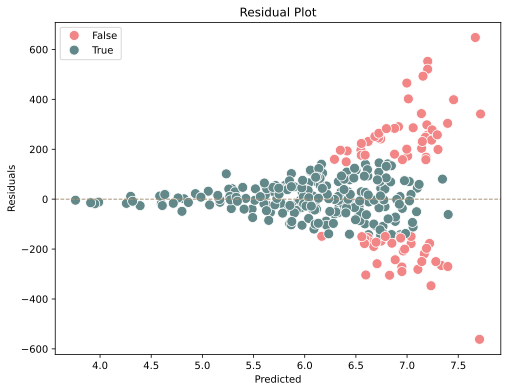

In [13]:
# Calculate residuals
residuals = np.expm1(y_test) - np.expm1(y_pred)

# Calculate standard deviation of residuals
sigma = np.std(residuals)

# Create a list for hue parameter
hue = list(map(lambda x: abs(x) < sigma, residuals))

# Create a residual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, hue=hue, palette = ['#f28585', '#638889'], s=100)
plt.axhline(y=0, color='#A79277', linestyle='--', lw=1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Hyperparameter Tuning

In [14]:
# # Define your CatBoostRegressor
# model = CatBoostRegressor()

# # Define the parameter distribution
# param_dist = {
#     'depth': np.arange(3, 11, 1),
#     'learning_rate': np.linspace(0.01, 0.1, 10),
#     'iterations': np.arange(30, 501, 20),
#     'l2_leaf_reg': np.arange(1, 6, 1),
#     'subsample': np.linspace(0.8, 1, 5)
# }

# # Create a RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=150,  # Number of parameter settings that are sampled
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=0,
#     random_state=42,  # For reproducibility
#     n_jobs=-1
# )

# # Fit the RandomizedSearchCV object to the data
# random_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = random_search.best_params_
# print("Best parameters: ", best_params)

### Applying the Hyperparameters to the model and Visualizing the log Loss

In [15]:
# Create a CatBoostRegressor model with specified hyperparameters
model = CatBoostRegressor(verbose=0, subsample=0.9, learning_rate=0.05000000000000001, l2_leaf_reg=2,
                          iterations=350, depth=4)

# Fit the model to the training data
model.fit(X_train, y_train)

# Extract feature importances from the trained model
feature_coefficients = pd.DataFrame(model.feature_importances_, index=X.columns,
                                    columns=['Importance']).sort_values(by='Importance', ascending=False)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R-squared (R2) score using the predictions and true target values
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

# Print the R-squared (R2) score
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.8969610131255434


### Visualization of Validation RMSE Over Iterations

This section demonstrates the visualization of the Root Mean Squared Error (RMSE) values during the training process using the CatBoostRegressor model.

1. **Model Fitting with Evaluation Set:**  
   The model is fitted to the training data (`X_train`, `y_train`) with an evaluation set specified as (`X_test`, `y_test`). This allows the model to evaluate its performance on the validation set during training. The `use_best_model=True` parameter ensures that the best model based on validation performance is retained.

2. **Get Log Loss Values:**  
   After training, the RMSE values on the validation set for each iteration are obtained using the `get_evals_result()` method of the model. The RMSE values are extracted from the 'validation' dictionary.

3. **Plot Validation RMSE Over Iterations:**  
   Using matplotlib, a line plot is created to visualize the change in RMSE over iterations during training. The x-axis represents the number of iterations, while the y-axis represents the RMSE values. The plot helps in understanding how the model's performance on the validation set evolves over the training process.


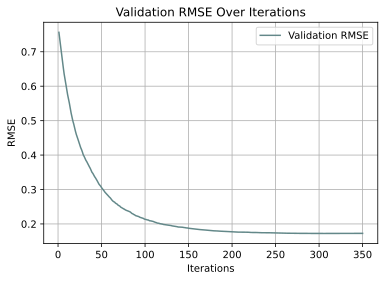

In [16]:
# Fit the model to the training data and evaluate it on the test set
# use_best_model=True ensures that the model uses the best iteration based on early stopping
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Get the RMSE values during training from the evaluation set
train_log_loss = model.get_evals_result()['validation']['RMSE']

# Plot RMSE over iterations
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(train_log_loss) + 1), train_log_loss, label='Validation RMSE', color='#638889')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Validation RMSE Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


### Visualizing Feature Importances

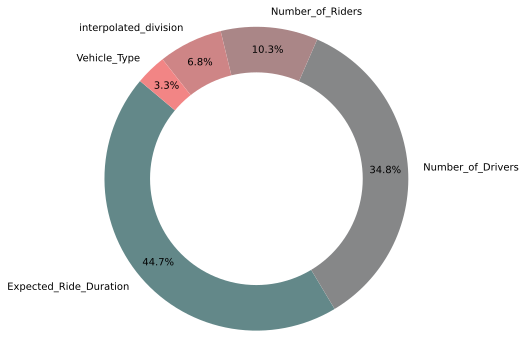

In [17]:
plt.figure(figsize=(6, 6))

# Create a pie chart
plt.pie(feature_coefficients['Importance'].values, labels=feature_coefficients.index, autopct='%1.1f%%', startangle=140, 
        colors = ['#638889', '#868788', '#aa8687', '#ce8586', '#f28585'], labeldistance = 1.1,
                  pctdistance = 0.85, normalize=True
)

# Draw a circle in the center to create a ring
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.show()


In [ ]:
# Save the model to a file
with open('../models/dynamic_pricing_model.pkl', 'wb') as file:
    dill.dump(model, file)